<a href="https://colab.research.google.com/github/fabrytp8/AG1/blob/main/act_c1_c2/Actividad_C1_P1_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

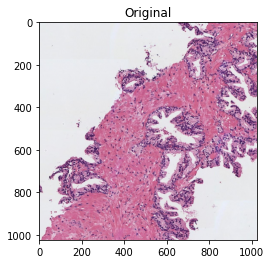

In [ ]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen
from skimage import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = io.imread('images/histo_1.jpg')
img = img.astype(float)/255.
# img=img/255
# img=np.float32(img/255)
plt.title('Original')
plt.imshow(img)
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

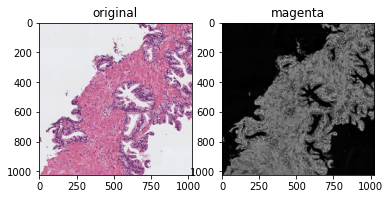

In [ ]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta
with np.errstate(invalid='ignore', divide='ignore'):
	K = 1 - np.max(img, axis=2)
	C = (1-img[...,2] - K)/(1-K)
	M = (1-img[...,1] - K)/(1-K)
	Y = (1-img[...,0] - K)/(1-K)

CMYK = (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)
# CMYK = (np.dstack((C,M,Y,K)))
C,M,Y,K = cv2.split(CMYK)
# plt.imshow(M.astype('uint8'),cmap='gray')
# plt.show()
fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(M.astype('uint8'), cmap='gray'), ax[1].set_title('magenta')
plt.show()


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

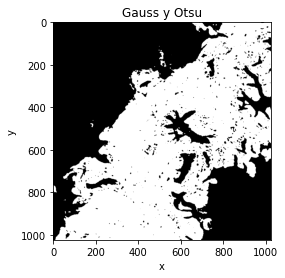

In [ ]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante
img_gauss = cv2.GaussianBlur(M.astype('uint8'),(5,5),0)
_, mask = cv2.threshold(img_gauss,0,1,cv2.THRESH_OTSU)
plt.imshow(mask,cmap='gray')
plt.title('Gauss y Otsu')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

c:\users\fabry\appdata\local\programs\python\python39\lib\site-packages\skimage\_shared\utils.py:112: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
c:\users\fabry\appdata\local\programs\python\python39\lib\site-packages\skimage\_shared\utils.py:112: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


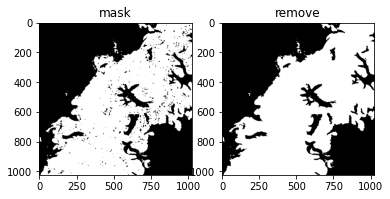

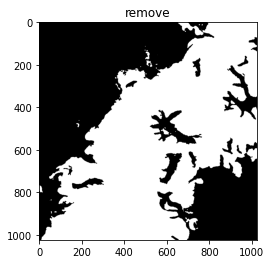

In [ ]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
img_remove1 = remove_small_objects(mask,300)
img_remove = remove_small_holes(img_remove1,300)
fig,ax = plt.subplots(1,2)
ax[0].imshow(mask,cmap='gray'),ax[0].set_title('mask')
ax[1].imshow(img_remove,cmap='gray'),ax[1].set_title('remove')
# ax[2].imshow(img_remove2,cmap='gray')
plt.show()
plt.imshow(img_remove,cmap='gray')
plt.title('remove')
plt.show()


#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

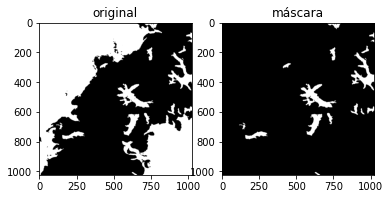

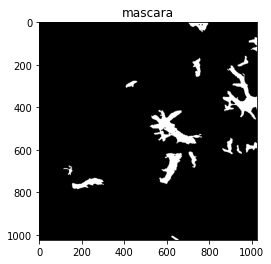

In [ ]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 
img_neg=img_remove.copy()
img_neg=~img_neg
# plt.imshow(img_neg,cmap='gray')
# plt.show()
mask=img_neg.astype('uint8').copy()
h,w = img_remove.shape
ref = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(mask, ref, (0,0), 0)
mask2=mask.copy()
cv2.floodFill(mask2,ref,(1000,1000),0)
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_neg, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(mask2, cmap='gray'), ax[1].set_title('máscara')
plt.show()
plt.imshow(mask2,cmap='gray')
plt.title('mascara')
plt.show()



#### 5) Rellenar los objetos de los lúmenes

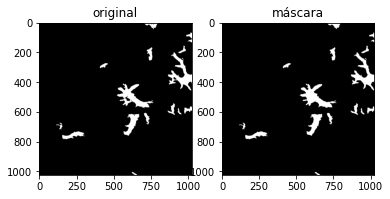

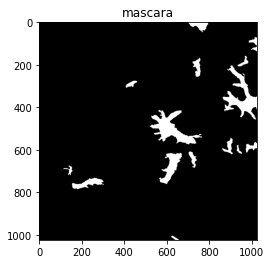

In [ ]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante
from scipy.ndimage.morphology import binary_fill_holes as bfh
filled_bordes = bfh(mask2)
fig, ax = plt.subplots(1,2)
ax[0].imshow(mask2, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(filled_bordes, cmap='gray'), ax[1].set_title('máscara')
plt.show()
plt.imshow(filled_bordes,cmap='gray')
plt.title('mascara')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


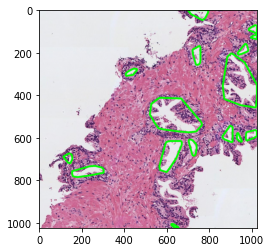

In [ ]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta
from skimage.morphology import convex_hull_image
from skimage.measure import label

lab, num = label(filled_bordes, return_num=True)

imagen = img.copy()
for i in range(1, num+1): 
    objeto = lab == i
    objeto = objeto.astype('uint8')
    # covex hull
    convex_image = convex_hull_image(objeto)
    convex_image = convex_image.astype('uint8')
    conts,_ = cv2.findContours(convex_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen = cv2.drawContours(imagen, conts, -1, (0,255,0), 8)
plt.imshow(imagen, cmap='gray')
plt.show()

#### 7) Identificar y cropear el lumen más grande

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2434, 745, 309, 841, 1903, 13190, 882, 14110, 1503, 1283, 407, 1332, 6584, 603, 3683, 306]


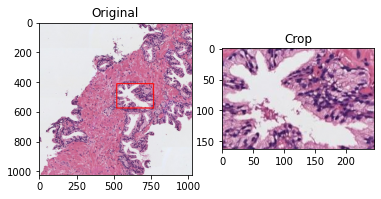

In [ ]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.
# from skimage.morphology import convex_hull_image
from skimage.measure import regionprops
from skimage.measure import label
from tabulate import tabulate
import math

new_lab, new_num = label(filled_bordes, return_num=True)

prop = regionprops(objeto.astype(np.uint8))

A=[]
for i in range(1,new_num+1):
    objeto = new_lab == i
    prop = regionprops(objeto.astype(np.uint8))
    A.append(np.round(prop[0].area, 4))
print(A)
# print(max(A))
# print(A.index(max(A)))
# objeto=new_lab ==8
i=A.index(max(A))+1
objeto = new_lab == i
prop = regionprops(objeto.astype(np.uint8))
bbox = prop[0].bbox
crop =  img[bbox[0]:bbox[2], bbox[1]:bbox[3]]
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])
window = cv2.rectangle(img.copy(), start_point, end_point, (255, 0, 0), 5)
fig,ax = plt.subplots(1,2)
ax[0].imshow(window,'gray'),ax[0].set_title('Original')
ax[1].imshow(crop,'gray'),ax[1].set_title('Crop')
plt.show()


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [ ]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad
from tabulate import tabulate
import math

new_lab, new_num = label(mask, return_num=True)

# Extraemos las característicias geométricas
headers = ['','AREA MAXIMA']
A,BB,CA,E,ED,EX,FE,MA,MiA,OR,P,S,CO,R = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'],['feret'], ['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness'], ['rectangularity']

objeto = new_lab == i
prop = regionprops(objeto.astype(np.uint8))
A.append(np.round(prop[0].area, 4))
BB.append(np.round(prop[0].bbox_area, 4))
CA.append(np.round(prop[0].convex_area, 4))
E.append(np.round(prop[0].eccentricity, 4))
ED.append(np.round(prop[0].equivalent_diameter, 4))
EX.append(np.round(prop[0].extent, 4))
FE.append(np.round(prop[0].feret_diameter_max, 4))
MA.append(np.round(prop[0].major_axis_length, 4))
MiA.append(np.round(prop[0].minor_axis_length, 4))
OR.append(np.round(prop[0].orientation, 4))
P.append(np.round(prop[0].perimeter, 4))
S.append(np.round(prop[0].solidity, 4))
CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
R.append(np.round(prop[0].area/prop[0].bbox_area, 4))


my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(FE),tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO), tuple(R)]

print(tabulate(my_data, headers=headers,floatfmt=".4f"))

                  AREA MAXIMA
--------------  -------------
area                 826.0000
bbox_area           1824.0000
convex_area          928.0000
eccentricity           0.9504
equiv_diameter        32.4299
extent                 0.4529
feret                 57.6888
major_axis            59.5200
minor_axis            18.5042
orientation           -0.9779
perimeter            138.7107
solidity               0.8901
compactness            0.5395
rectangularity         0.4529
